In [1]:
# libraries for data handling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# libraries specific for Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv


In [2]:
df = pd.read_csv("/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv")

In [3]:
df.head()

,Date Read,Author,Books,Year Published,Pages,Favorite
0,Jun-68,Jean-Jacques Rousseau,The Confessions,1781,606,1
1,Jun-68,Erich Fromm,The Art of Loving,1956,146,1
2,Jun-68,Mark Twain,The Adventures of Huckleberry Finn,1884,288,0
3,Jul-68,James Thurber,My Life and Hard Times,1933,115,0
4,Jul-68,William Shakespeare,Romeo and Juliet,1596,146,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date Read       1321 non-null   object
 1   Author          1321 non-null   object
 2   Books           1321 non-null   object
 3   Year Published  1321 non-null   object
 4   Pages           1321 non-null   int64 
 5   Favorite        1321 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 62.0+ KB


## Books

In [5]:
df["Books"].nunique()

1305

In [6]:
df["Books"].value_counts()

The Confessions                               3
Autobiography                                 3
The Last Interview                            2
Othello                                       2
The Europeans                                 2
                                             ..
The Solace of Open Spaces                     1
Notes from the Underground                    1
Tom Sawyer Abroad and Tom Sawyer Detective    1
Singers and the Song                          1
Saving Freedom                                1
Name: Books, Length: 1305, dtype: int64

In [7]:
df[df["Books"].duplicated()].sort_values(by = "Books").head()

,Date Read,Author,Books,Year Published,Pages,Favorite
167,Dec-79,W.B. Yeats,Autobiography,1922,387,0
192,Jul-81,Benvenuto Cellini,Autobiography,1562,397,0
262,Sep-83,Aaron Copland,Copland on Music,1959,280,0
1192,Oct-13,Witold Gombrowicz,Cosmos,1967,208,0
836,Dec-00,Sir Harold Nicolson,Diplomacy,1939,151,0


In [8]:
# different books?
df[df["Books"]=="Othello"]

,Date Read,Author,Books,Year Published,Pages,Favorite
49,Jan-71,William Shakespeare,Othello,1602,128,0
317,Oct-84,William Shakespeare,Othello,1604,154,0


In [9]:
# no fav books in duplicates and therefore favorits dont change between rereads 
df[df["Books"].duplicated()]["Favorite"].sum()

0

## Favorite

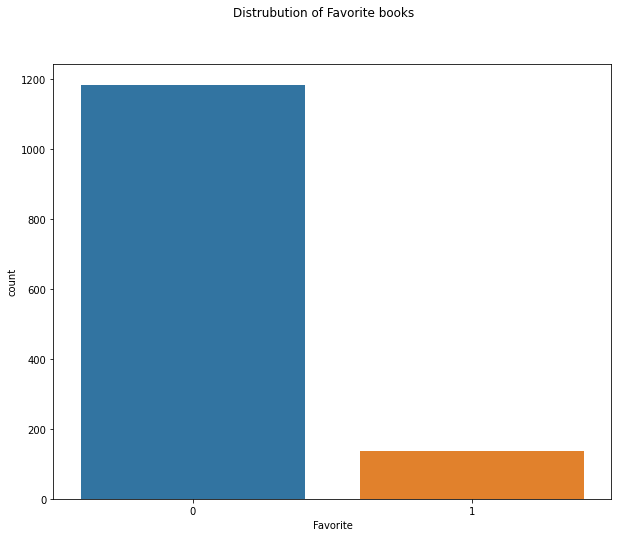

In [10]:
plt.figure(figsize = (10,8))
sns.countplot(x = "Favorite", data = df)
plt.suptitle("Distrubution of Favorite books")
plt.show()

In [11]:
print(round(((df[df["Favorite"] ==1].shape[0]/df.shape[0])*100),3), "% of the books were favorites")

10.295 % of the books were favorites


## Author

In [12]:
df["Author"].value_counts()

William Shakespeare      15
Charles Dickens          10
Jean-Jacques Rousseau     9
Marcel Proust             8
Various                   7
                         ..
J.P. Kenyon               1
Michel Foucault           1
Ian Frazier               1
Anne Rice                 1
Joe Scarborough           1
Name: Author, Length: 966, dtype: int64

In [13]:
# favorite authors exist
df.groupby("Author")["Favorite"].sum().sort_values(ascending=False)

Author
Marcel Proust                    5
L.N. Tolstoy                     4
Jean Rhys                        3
Vladimir Nabokov                 2
Mark Twain                       2
                                ..
Giambattista Vico                0
Giorgio Vasari                   0
Giovanni Boccaccio               0
Giovanni Pico della Mirandola    0
editor, Eric L. McKitrick        0
Name: Favorite, Length: 966, dtype: int64

In [14]:
# multiple author books
#df["Author"].unique()

df["Author"].str.split(',', expand=True).dropna(thresh=2)

,0,1,2,3
17,Jule Eisenbud,M.D.,None,None
107,Kurt Vonnegut,Jr.,None,None
211,David C. Gompert,Michael Mandelbaum,Richard L. Garwin,John H. Barton
213,Willard Gaylin,Ira Glasser,Steven Marcus,David Rochman
275,Sappho,Pindar,Solon,and 23 others
288,William Strunk,Jr. and E.B. White,None,None
434,Roger Fisher,William Ury,None,None
453,Michael J. Malbin,ed.,None,None
506,Noam Chomsky,Edward S. Herman,None,None
522,Paul Magriel,John T. Spike,None,None


## pages

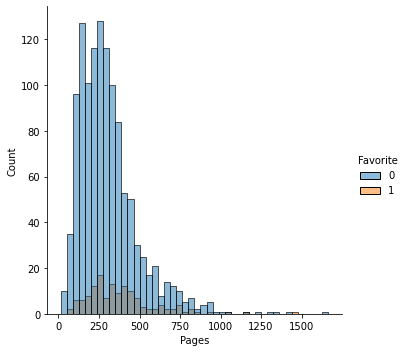

In [15]:
sns.displot(x= "Pages", data = df, hue = "Favorite")

<AxesSubplot:xlabel='Pages'>

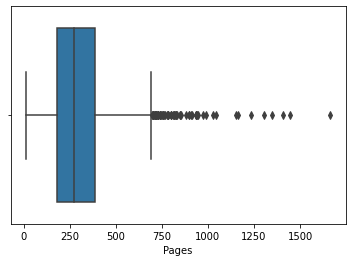

In [16]:
sns.boxplot(x= "Pages", data = df, )

# Year published 

typos and BC/AC dates need to be fixed or python will handle these as objects/string

In [17]:
df[df["Year Published"]=="730bc"]

,Date Read,Author,Books,Year Published,Pages,Favorite
139,Jun-78,Homer,The Iliad,730bc,459,0


In [18]:
# rectify the two typos
df["Year Published"].replace(["1,981","398ad"], ["1981","398"],  inplace = True)

# convert BC dates to negative numbers
df["Year_Published_numerical"] = df["Year Published"].apply(lambda x: "-"+x[:-2] if x[-2:]=="bc" else x)

# revise the data to numerical values
df["Year_Published_numerical"] = df["Year_Published_numerical"].astype(int)

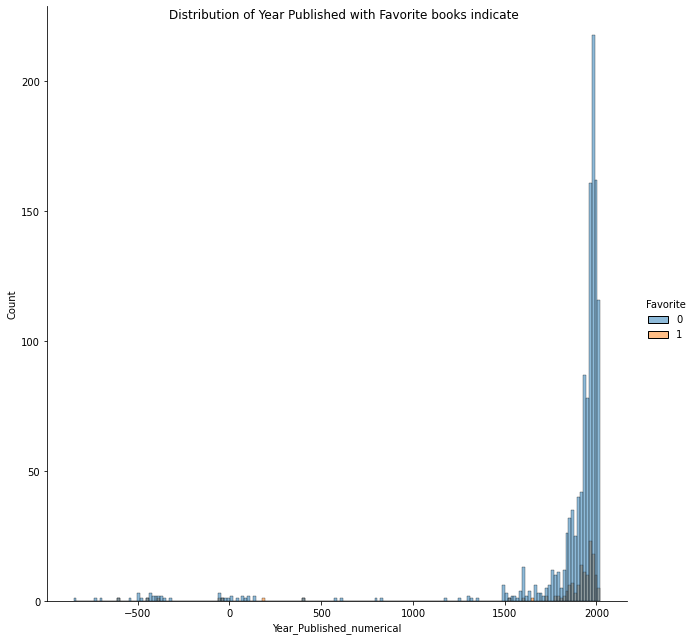

In [19]:
sns.displot(x = "Year_Published_numerical", data = df, hue = "Favorite", height = 9)
plt.suptitle("Distribution of Year Published with Favorite books indicate")
plt.show()

<AxesSubplot:xlabel='Year_Published_numerical'>

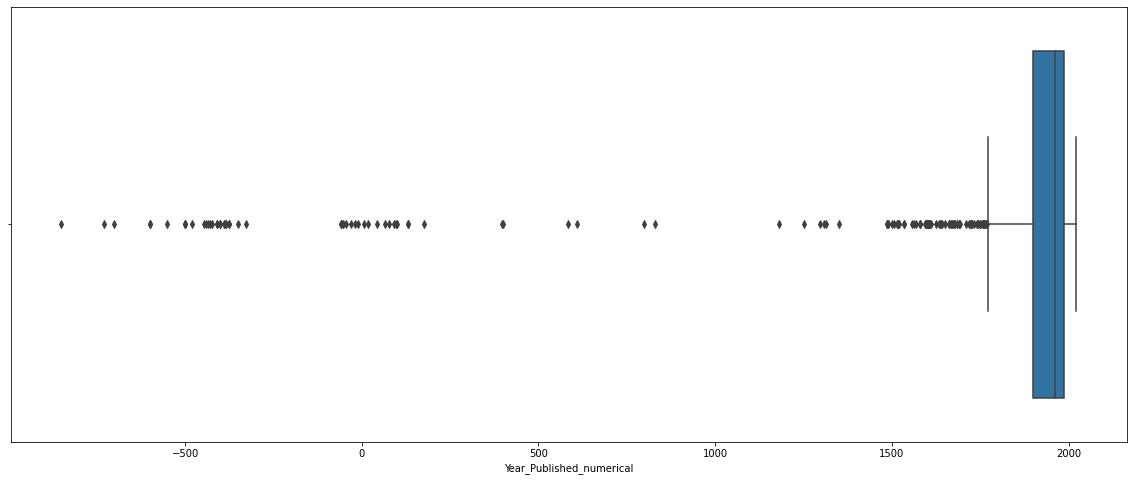

In [20]:
plt.figure(figsize = (20,8))
sns.boxplot(x= "Year_Published_numerical", data = df, )

In [21]:
df["Year_Published_numerical"].describe()

count    1321.000000
mean     1848.776684
std       422.118396
min      -850.000000
25%      1900.000000
50%      1963.000000
75%      1987.000000
max      2021.000000
Name: Year_Published_numerical, dtype: float64

# Date Read

In [22]:
df["Date Read"].unique()

array(['Jun-68', 'Jul-68', 'Aug-68', 'Sep-68', 'Oct-68', 'Nov-68',
       'Dec-68', 'Jan-69', 'Feb-69', 'May-69', 'Jun-69', 'Jul-69',
       'Aug-69', 'Sep-69', 'Jan-70', 'Feb-70', 'Mar-70', 'Apr-70',
       'May-70', 'Jul-70', 'Aug-70', 'Sep-70', 'Oct-70', 'Nov-70',
       'Dec-70', 'Jan-71', 'Feb-71', 'Mar-71', 'Apr-71', 'Jun-71',
       'Jul-71', 'Aug-71', 'Sep-71', 'Oct-71', 'Nov-71', 'Dec-71',
       'Jan-72', 'Feb-72', 'Mar-72', 'Apr-72', 'Aug-72', 'Sep-72',
       'Oct-72', 'Feb-73', 'Apr-73', 'Jun-73', 'Jul-73', 'Aug-73',
       'Sep-73', 'Oct-73', 'Nov-73', 'Dec-73', 'Jan-74', 'Feb-74',
       'Mar-74', 'Apr-74', 'May-74', 'Jul-74', 'Aug-74', 'Oct-74',
       'Nov-74', 'Dec-74', 'Feb-75', 'Jun-75', 'Sep-75', 'Jan-76',
       'Feb-76', 'Mar-76', 'Apr-76', 'Jul-76', 'Dec-76', 'Jan-77',
       'Feb-77', 'May-77', 'Jun-77', 'Jul-77', 'Sep-77', 'Aug-77',
       'Nov-77', 'Dec-77', 'Mar-78', 'Apr-78', 'May-78', 'Jun-78',
       'Aug-78', 'Sep-78', 'Nov-78', 'Feb-79', 'Mar-79', 'May-

In [23]:
# fix syntax setting xxx for months unknown
df["Date Read"] = df["Date Read"].apply(lambda x: x if len(x)>5 else "xxx-"+x[-2:])

In [24]:
df[["Month", "Year"]] = df["Date Read"].str.split('-', expand=True)

In [25]:
df["Year"] = df["Year"].astype(int)

In [26]:
df["Year"] = df["Year"].apply(lambda x: x+2000 if x <68 else x+1900)
 

In [27]:
df[df["Month"]=="xxx"].shape[0]

125

In [28]:
(df[df["Month"]=="xxx"].shape[0]/df.shape[0])*100

9.462528387585163

In [29]:
(sum(df[df["Month"]=="xxx"]["Favorite"])/sum(df["Favorite"]))*100

2.941176470588235

In [30]:
df[df["Month"]=="xxx"]["Year"].unique()

array([2005, 2006, 2007, 2008, 2018, 2019, 2020, 2021])

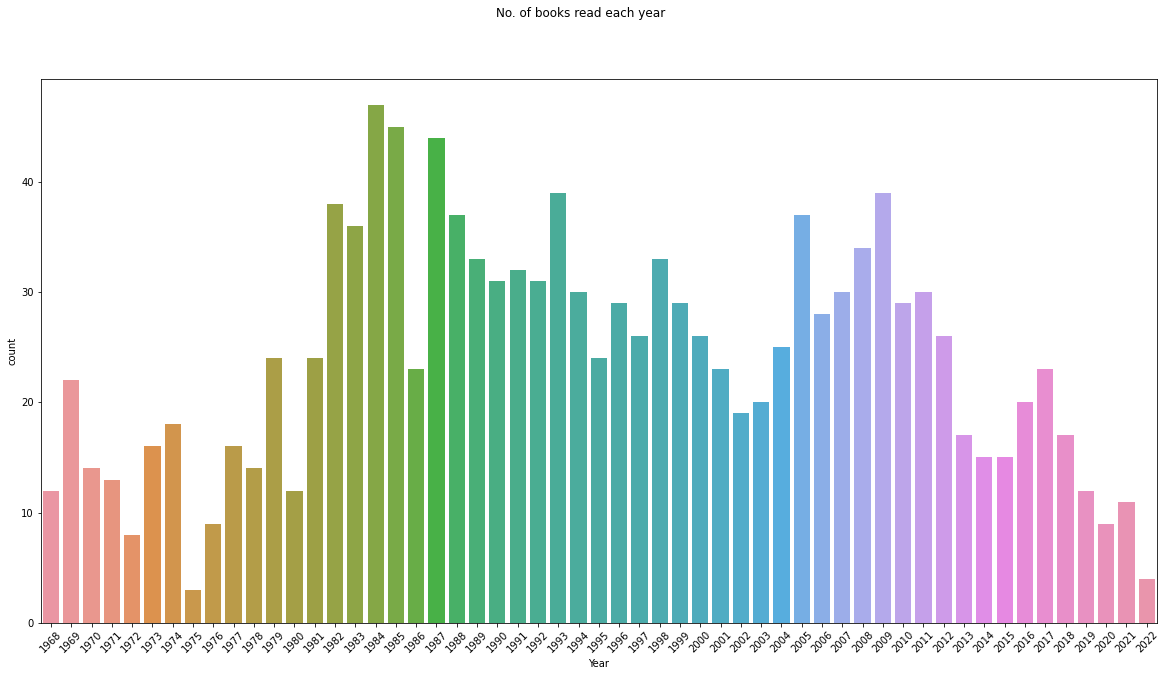

In [31]:
plt.figure(figsize = (20,10))
sns.countplot( x = "Year", data = df)
plt.suptitle("No. of books read each year")
plt.xticks(rotation = 45)
plt.show()

 first attempt not include month

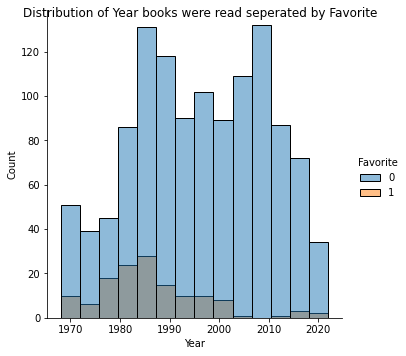

In [32]:
sns.displot(x = "Year", data = df, hue = "Favorite")
plt.suptitle("Distribution of Year books were read seperated by Favorite")
plt.show()

In [33]:
df[df["Month"]=="xxx"]

,Date Read,Author,Books,Year Published,Pages,Favorite,Year_Published_numerical,Month,Year
926,xxx-05,Lawrence Potter,The Persian Gulf in Transition,1997,336,0,1997,xxx,2005
927,xxx-05,Immanuel Kant,Perpetual Peace,1795,160,0,1795,xxx,2005
928,xxx-05,Bob Dylan,"Chronicles, vol. 1",2004,320,0,2004,xxx,2005
929,xxx-05,Arthur Koestler,The Gladiators,1949,44,0,1949,xxx,2005
930,xxx-05,Richard L. Bushman,From Puritan to Yankee,1967,352,0,1967,xxx,2005
...,...,...,...,...,...,...,...,...,...
1303,xxx-20,Doris Kearns Goodwin,Leadership,2020,397,0,2020,xxx,2020
1304,xxx-20,David Mikie,Stanley Kubrick,2020,248,0,2020,xxx,2020
1305,xxx-20,Julie Satow,The Plaza,2019,358,0,2019,xxx,2020
1306,xxx-20,Ash Carter and Sam Kashner,Life Isn’t Everything – Mike Nichols as Rememb...,2019,368,0,2019,xxx,2020


# Modelling Favourites

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
le = LabelEncoder()
df["Author_code"] = le.fit_transform(df["Author"])

In [36]:
x = df[["Author_code", "Year_Published_numerical", "Pages", "Year"]]
y = df["Favorite"]

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


In [38]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 360 )

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [41]:
predictions = logmodel.predict(X_test)

In [42]:
from sklearn.metrics import classification_report

In [43]:
print("Logistic Model - reading month excluded")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
# nope.. 

Logistic Model - reading month excluded
[[357   1]
 [ 39   0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       358
           1       0.00      0.00      0.00        39

    accuracy                           0.90       397
   macro avg       0.45      0.50      0.47       397
weighted avg       0.81      0.90      0.85       397



In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
RandomForest_pred = RandomForest.predict(X_test)

In [47]:
print("Random Forest Model - reading month excluded")

print(confusion_matrix(y_test,RandomForest_pred))
print(classification_report(y_test, RandomForest_pred))

Random Forest Model - reading month excluded
[[351   7]
 [ 37   2]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       358
           1       0.22      0.05      0.08        39

    accuracy                           0.89       397
   macro avg       0.56      0.52      0.51       397
weighted avg       0.84      0.89      0.86       397



# month known

In [48]:
df.drop(df[df["Month"]=="xxx"].index, axis = 0, inplace = True)

In [49]:
df["Month_no"] = pd.to_datetime(df["Month"], format = "%b").dt.month

In [50]:
x = df[["Author_code","Month_no", "Year_Published_numerical", "Pages", "Year"]]
y = df["Favorite"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 360 )

In [52]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [53]:
predictions = logmodel.predict(X_test)

In [54]:
print("Logistic Model - reading month included")

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

Logistic Model - reading month included
[[314   1]
 [ 44   0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       315
           1       0.00      0.00      0.00        44

    accuracy                           0.87       359
   macro avg       0.44      0.50      0.47       359
weighted avg       0.77      0.87      0.82       359



In [55]:
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train, y_train)

RandomForestClassifier()

In [56]:
RandomForest_pred = RandomForest.predict(X_test)

In [57]:
print("Random Forest Model - reading month included")

print(confusion_matrix(y_test,RandomForest_pred))
print(classification_report(y_test, RandomForest_pred))

Random Forest Model - reading month included
[[311   4]
 [ 42   2]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       315
           1       0.33      0.05      0.08        44

    accuracy                           0.87       359
   macro avg       0.61      0.52      0.51       359
weighted avg       0.81      0.87      0.83       359

